<a href="https://colab.research.google.com/github/justinsydnor/GB894/blob/main/CompasLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness Analysis of the COMPAS Algorithm
Case study for General Business 894

Created by Professor Justin Sydnor

Last edited 5/15/2025
## Background on the case
This Notebook provides a step-by-step fairness analysis for an example demonstration of the Compas Algorithm.

Propublica first broke a story about apparent bias and unfairness in an algorithm produced by the company Compas to predict recidivism risk after arrest. The original Propublica story can be found [here](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing).  Propublica argued that individuals who ultimately did not recidivate were significantly more likely to have been labeled as "high risk" if they were black than if they were white. Compas disputed that the model was unfair, arguing that it was well-calibrated overall and across different racial subgroups. This debate caught the attention of academic research teams who set out to reconcile the fact that these different ways of measuring fairness seemed to be giving conflicting answers for this situation. What the research teams uncovered was that there was actually a mathematical reason that any risk-profiling classification system would show this inconsistency. As long as the subgroups have different base rates, a well-calibrated model will necessarily have differential false-positive and false-negative rates of the type documented by the Propublica Story. In the aftermath of these investigations, Propublica published an article about these findings on the inconsistency of fairness metrics that can be found [here](https://www.propublica.org/article/bias-in-criminal-risk-scores-is-mathematically-inevitable-researchers-say).

The goal of this notebook is to conduct a fairness analysis on data similar to the original data from the Compas algorithm to visualize these findings.

## Overview of the data for this case
Propublica assembled the original data for their investigation through open records requests for individuals arrested in Florida. They have a [github repository](https://github.com/propublica/compas-analysis) with their original data and details of their analysis. They also detail the analysis they did [here](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

For this notebook, I will not work with the original Propublica data, but instead a cleaned and processed version of the data that is available from r-project.org as part of the Package *fairness*. Here is a [description of the data](https://search.r-project.org/CRAN/refmans/fairness/html/compas.html). The main difference in these data versus the original Propublica data is that these data have been processed to produce a set of predicted probabilities (based presumably on the original Compas scores obtained by Propublica). This makes them more useful for assessing calibration of the underlying model. It should be noted, however, that these predicted probabilities were not generated directly by Compas. The data used here should be recognized as only illustrive and useful for this educational lab simulation and not as part of an analysis of the actual Compas algorithm. I further adapted the r-project data to simplify to only have two ethnicity groups (Caucasian and African American) and I created a numeric factor variable to capture the outcome of recidivism (which is coded as a text yes/no in the r-project data).

A note on the use of the term "ethnicity" in this notebook. The original data from the r-project is labeled as "ethnicity" because it includes categories for Hispanic ethnicity. My limiting the data to Caucasian and African American would likely be more appropriately labeled as "race" rather than "ethnicity". Throughout this notebook, however, I will keep with the term "ethnicity" for consistency with the r-project data and other analysis notebooks students might find that use these same data.

## Getting started with the Lab
Ok, now it's time to get started going through the lab. Run the code chunks in order and read the discussion as you go. Make sure to take a look at the output that is generated after the code runs.

We begin by loading in the data...

# Loading in the data

In [3]:
# Load in the data compass_mine.csv

import pandas as pd

url = "https://raw.githubusercontent.com/justinsydnor/GB894/refs/heads/main/compas894.csv"
df = pd.read_csv(url)
print(df.head())


     v1 two_yr_recidivism  number_of_priors age_above_fourtyfive  \
0  5068                no         -0.684358                   no   
1  5459                no         -0.684358                  yes   
2  2316                no         -0.684358                   no   
3   788                no         -0.051949                  yes   
4  1649                no         -0.473555                   no   

  age_below_twentyfive  female misdemeanor         ethnicity  probability  \
0                   no    Male         yes  African_American     0.367219   
1                   no  Female          no  African_American     0.179368   
2                   no    Male          no  African_American     0.415220   
3                   no    Male         yes  African_American     0.326497   
4                   no    Male          no  African_American     0.450548   

   predicted  recidivism  
0          0           0  
1          0           0  
2          0           0  
3          0        

We see after the quick data print that we have a number of variables here. The key ones will be **recidivism**, which is an indicator taking values 1 if the individual was rearrested within two years (labeled as "yes" in the variable **two_yr_recidivism**) and 0 otherwise. We also see the variable **probability** and the variable **predicted**. We can use the next chunk of code to see which levels of probability were used to classify (i.e., what was the probability threshold for classification as high-risk?).

# Basic data exploration
Now that we have the data loaded, we start by creating a simple table to look at the range (minimum and maximum) and average (mean) of the three key variables in our data (**recidivism**, **probability**, **predicted**).

In [15]:
# Create a table showing the minimum, mean, and maximum of the variables "recidivism", "predicted", and "probability"
summary_stats = df[['recidivism', 'probability', 'predicted']].agg(['min', 'mean', 'max'])

# Round to 2 decimal places
summary_stats = summary_stats.round(2)

# Display the rounded table
print(summary_stats)



      recidivism  probability  predicted
min         0.00         0.14       0.00
mean        0.47         0.51       0.48
max         1.00         1.00       1.00


Ok, we can see here that **recidivism** ranges from 0 to 1, which corresponds to our knowledge that it is a binary indicator and has a mean of 47% in this sample. We see that the **probability** ranges from 14% to 100% and has a mean slightly higher at 51%. This gives us an indication that the probability model is sensible, though perhaps not perfect, since the average probability is close to the average rate of recidivism. We would be worried if that were not true. We will investigate the calibration of the model more below. Finally when we look at the binary variable **predicted** we see that it has an average of 48%, which again is close to the true average rate of recidivism.

It is helpful to check how **predicted** is constructed from **probability**. There was likely a simple threshold rule used for classificaiton here, but it is not entirely clear what that threshold was. We can easily figure it out by summarizing **probability** for each of the levels of **predicted**

In [17]:
# Create a table showing the minimum, mean, and maximum predicted probability by the variable "predicted". This lets us see what threshold is being used.
summary_stats = df.groupby('predicted')['probability'].agg(['min', 'mean', 'max'])

# Round to 2 decimal places
summary_stats = summary_stats.round(4)#Note using 4 decimals here to see the threshold better.

# Display the rounded table
print(summary_stats)

              min    mean     max
predicted                        
0          0.1369  0.3611  0.4999
1          0.5001  0.6660  0.9961


Ok, we can see here that the maximum predicted probability for those with "predicted = 0" is 0.4999 and for those with "predicted = 1" the minimum is 0.5001. This tells us that the threshold for classification was set at probability of 50%.



The next thing that is useful to do is to also plot out the distribution of the probability variable so we know how it is distributed. I do this using a histogram here (note we could also use a kernel density plot and a few other visualization approaches).

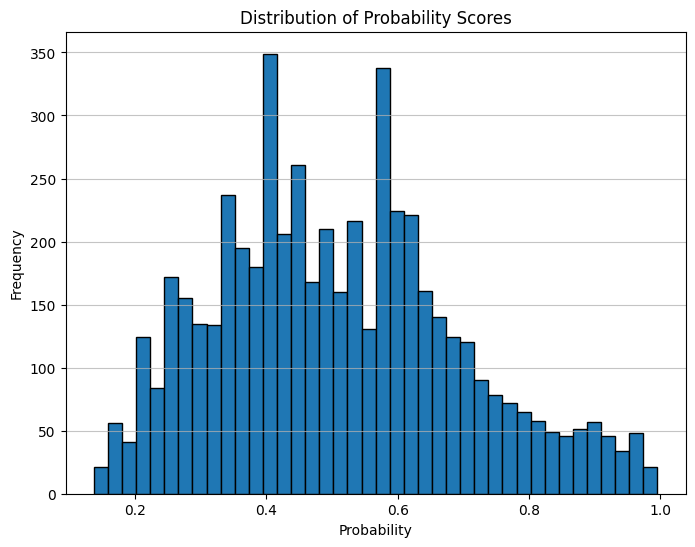

In [30]:
# Create a histogram of the variable probability

import matplotlib.pyplot as plt

# Create a histogram of the 'probability' variable
plt.figure(figsize=(8, 6)) # Optional: Adjust the figure size
plt.hist(df['probability'], bins=40, edgecolor='black') # You can adjust the number of bins
plt.title('Distribution of Probability Scores')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

So we see that the distribution is skewed a little with more mass at lower values around 40% than as values above 80%. We also see that there is some indication of the distribution being a little bimodal around 40% and 60%.

For this analysis we will take a look at differences by ethnic groups, specifically African American and Caucasion groups. To do that, let's look quickly at the distribution of ethnicities in the data.

In [38]:
# Tabulate the share of observations in each ethnicity
summary_stats = df['ethnicity'].value_counts(normalize=True)

# Round to 2 decimal places
summary_stats = summary_stats.round(2)

# Display the rounded table
summary_stats

,proportion
ethnicity,
African_American,0.6
Caucasian,0.4


We see that in these data about 60% of the sample is African American and 40% is Caucasian. Let's turn now to analyzing the differences in base rates and predicted values by ethnicity.

# Analysis of disparities in base rates and predicted probabilities


Now that we have a good sense of the basics of what the data look like and how classification was done, it is time to turn to our analysis of potential disparities between African American and Caucasian individuals.



##Base rates
We begin our analysis by looking at the "base rates" by subgroup. This is the average rate of observed actual recidivism by group. (*Important note: For this type of analysis it is also really important to think about how our outcome measure is recorded and whether their may be bias in this measurement across subgroups. We are ignoring that issue for the purposes of this notebook illustration, but it is a key step in real-world fairness analysis that requires you to step away from the data you have collected. Here we assume that there is no such bias and take these recidivism rates as "ground truth".*)

Here is a table showing the rate of recidivism by ethnicity group:

In [37]:
# Create a table showing the average rate of the variable recidivism by ethnicity group and limit the decimal places to 2.

# Create a table showing the average rate of recidivism by ethnicity group
recidivism_by_ethnicity = df.groupby('ethnicity')['recidivism'].mean()

# Round to 2 decimal places
recidivism_by_ethnicity = recidivism_by_ethnicity.round(2)

# Display the rounded table
recidivism_by_ethnicity

,recidivism
ethnicity,
African_American,0.52
Caucasian,0.39


We see here that the underlying base rate of recidivism in this sample is higher for African Americans than Caucasians (52% vs. 39%).

#Predicted probabilities
Next we look at the predicted probabilites by ethnicity. I like to begin such an analysis just understanding the minimum, mean, and maximum.

In [11]:
#Create a table showing the minimum, mean, and maximum predicted probability by ethnicity

import seaborn as sns
import matplotlib.pyplot as plt

# Group data by ethnicity and calculate min, mean, and max probability
summary_stats = df.groupby('ethnicity')['probability'].agg(['min', 'mean', 'max'])

# Round to 2 decimal places
summary_stats = summary_stats.round(2)

# Display the summary statistics as a table
print(summary_stats)



                   min  mean   max
ethnicity                         
African_American  0.15  0.56  1.00
Caucasian         0.14  0.43  0.99


So we see here that the range of predicted probabilities from the model is similar across ethnicities. For African American it ranges from 15% to 100%, while for Caucasian it ranges from 14% to 99%. The average, however, is higher African Americans (56% vs 43%). This tells us that the distribution of predicted probabilities is shifted up for African Americans relative to Caucasians.

Now let's take a look at comparing the distribution using overlapping histograms.


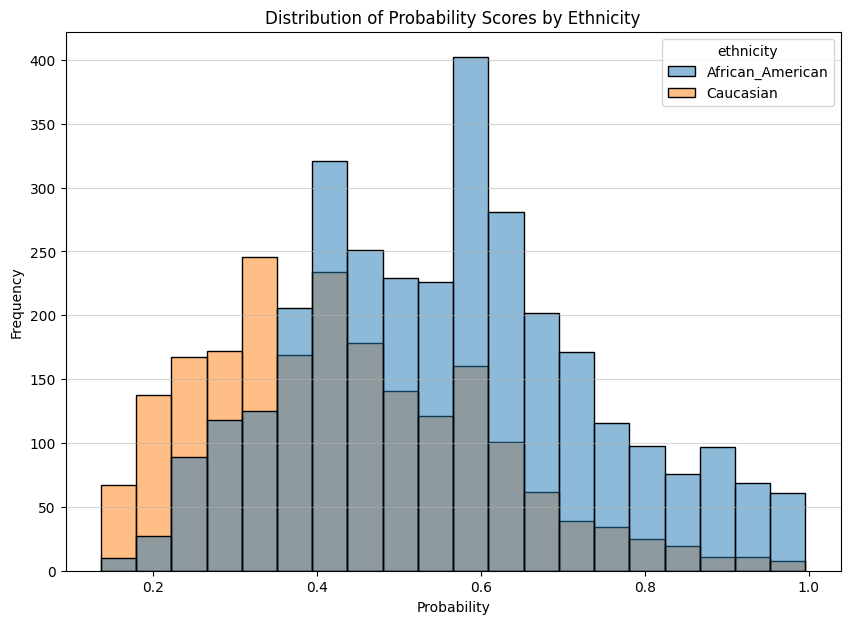

In [33]:

# Create overlapping histograms for probability by ethnicity
plt.figure(figsize=(10, 7))  # Adjust figure size

#Note that we have previously imported seaborn as sns. We can now use to generate the histogram
sns.histplot(
    data=df,
    x='probability',
    hue='ethnicity',
    multiple='layer',     # <- this overlays the histograms
    bins=20,
    kde=False,
    alpha=0.5             # <- set transparency
)

plt.title('Distribution of Probability Scores by Ethnicity')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

Ok, we can see from the histograms that the distribution is shifted up for African Americans, wich a strong peak around 60% predicted probability, while the Caucasian distribution peaks more around 30-40% and tails off from there.

A note on the overlapping histograms: Since this histogram is showing frequency counts, the bars are higher overall for the African American group since there are more of that group in the data. Ideally, I would prefer to show histograms as percentages of the total (i.e., fractions instead of frequencies). Unfortunately, if you try to use the built in python function to do this it will create a fraction of the full population rather than the fraction within ethnicity and that doesn't help the problem. We could code it up in a messier way by hand, but that's not so great.

Another way to see them in a comparable way that overcomes this issue is to graph the Kernel Density (KDE) plot comparisons. For a KDE in Seaborn graphed over groups (e.g., with hue in Seaborn), it calculates the density within each subgroup so that each curve integrates to 1 in the way you would expect. Here are the overlapping KDE plots.

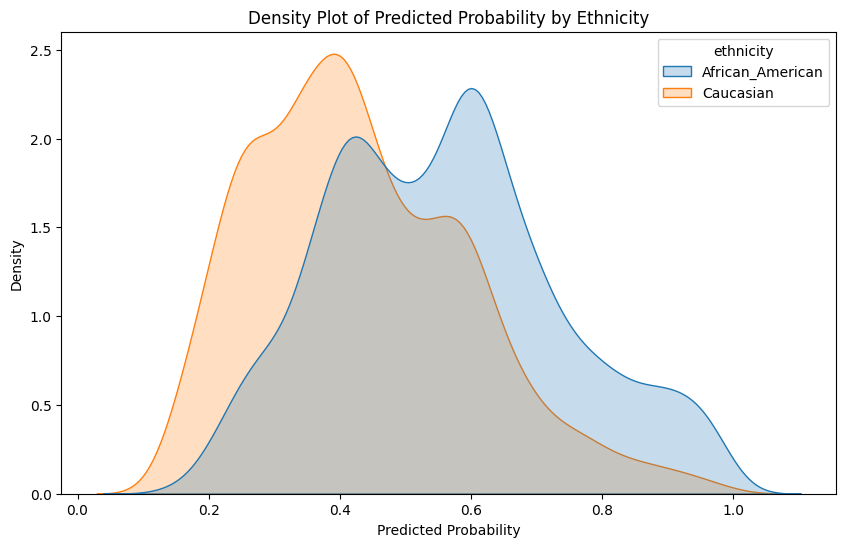

In [18]:
# prompt: Plot the density function of the predicted value labeled "probability" for both ethnicities with label "ethnicity"


# Assuming 'probability' and 'ethnicity' columns exist
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='probability', hue='ethnicity', fill=True, common_norm=False)
plt.title('Density Plot of Predicted Probability by Ethnicity')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.show()


This comparison makes it a lot easier to see clearly how the distribution of predicted probabilities is shifted over for the African American group relative to the Caucasian group.

## Classifications
The last thing we can do is look at the differences in rates of being classified as high risk (**predicted**=1) for the two ethnicities.

In [62]:
# Create a table showing the average rate of 'predicted' and 'recidivism' by ethnicity
average_rates = df.groupby('ethnicity')[['predicted', 'recidivism']].mean()

# Round to 2 decimal places
average_rates = average_rates.round(2)

# Display the rounded table
print(average_rates)

                  predicted  recidivism
ethnicity                              
African_American       0.59        0.52
Caucasian              0.32        0.39


We see now that the African American group was classified positive for high risk (predicted = 1) 59% of the time by the algorithm vs. 32% for Caucasians. The table also reproduces the average recidivism rates in each group that we saw above for easy comparison. We see that the differentials in predicted classification are similar to those in recidivism rates, but African Americans are predicted a little more other than they actually recidivate, while Caucasians are predicted a little less often than they recidivate.

#Assessing model calibration and accuracy
Now we turn to understanding whether the prediction model appears to be well calibrated and if that calibration is similar across the ethncity groups.

## Calibration curve
We begin with a calibration plot.

There is a package for making these calibration plots easily, which I use in the code below.

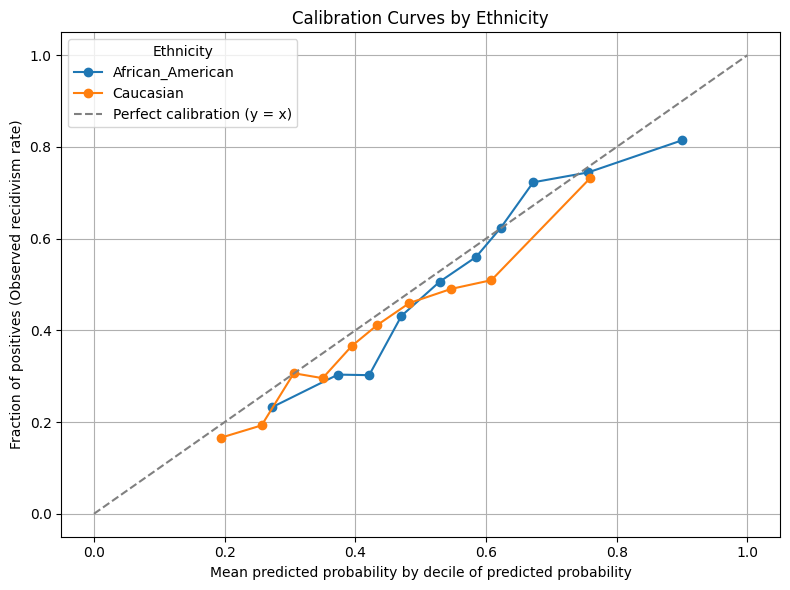

In [42]:
#Get the calibration curve package
from sklearn.calibration import calibration_curve

# Get unique ethnicities in the dataset
ethnicities = df['ethnicity'].unique()

# Initialize the plot
plt.figure(figsize=(8, 6))

# Plot calibration curves for each ethnicity
for group in ethnicities:
    group_df = df[df['ethnicity'] == group]
    y_true_group = group_df['recidivism']
    y_prob_group = group_df['probability']

    # Generate calibration curve for the group
    prob_true, prob_pred = calibration_curve(y_true_group, y_prob_group, n_bins=10, strategy='quantile')
    plt.plot(prob_pred, prob_true, marker='o', label=f'{group}')

# Add perfect calibration reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration (y = x)')

# Customize the plot
plt.xlabel('Mean predicted probability by decile of predicted probability')
plt.ylabel('Fraction of positives (Observed recidivism rate)')
plt.title('Calibration Curves by Ethnicity')
plt.legend(title='Ethnicity')
plt.grid(True)
plt.tight_layout()
plt.show()


Ok let's note a few things about this curve. First, notice that in the calibration curve step in the code we used 10 bins and set the "strategy='quantile'" in the command. This means that within each of our ethnicity groups, the code groups predictions into 10 bins and chooses those bins based on quantiles so they have equal shares of the data for the group (in this case that gives us deciles). This is a choice, we could look at fewer bins (e.g., 5 = quintiles of 20% in each bin) or instead of using quantiles we could group by fixed bin ranges. This basic approach of deciles is often a reasonable starting point, though.

Ok next we can see that the lines for both groups lie close to the 45-degree line of perfect calibration. Neither, though, likes perfectly on the line and for both groups the curve is a little below the perfect calibration line through most of the range. This is indicating that the prediction model is slightly over-predicting the likelihood of recidivism on average (e.g., for an average probability of 40%, the actual observed is a little below 40%). However, the overall differences are fairly small and most importantly there is not a clear visual disparity across the ethnicity groups in the calibration.



## Regression analysis of calibration
The next thing we can do to further assess calibration is to use a regression model to quantify whether the average difference between the average observed and average predicted values deviates more for the African American group. The idea is in a linear regression to regress the actual observed recidivism on the predicted probability and an indicator for the African American group. If the model is well calibrated for the Caucasian group the linear regression should show a slope coefficient of close to 1 and an intercept term close to 0. If there is no disparity, the coeffficient on African American should also be close to 0.

In [44]:
# Use a linear regression to regress recidivism on predicted with an indicator variable for ethnicity set to 1 for African_American and 0 for Caucasian and report the regression results

#import pandas as pd
import statsmodels.api as sm

# Create the indicator variable for ethnicity
df['african_american'] = (df['ethnicity'] == 'African_American').astype(int)

# Prepare the data for regression
X = df[['probability', 'african_american']]
y = df['recidivism']
X = sm.add_constant(X)  # Add a constant term to the independent variables

# Fit the linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             recidivism   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     438.8
Date:                Sat, 17 May 2025   Prob (F-statistic):          5.10e-177
Time:                        16:59:55   Log-Likelihood:                -3415.3
No. Observations:                5278   AIC:                             6837.
Df Residuals:                    5275   BIC:                             6856.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0464      0.019  

What we see here is further indication that the model is well calibrated and similarly so for each ethnicity. The estimated constant term of -0.0464 tells us that on average the actual rate of recidivism is about 5% lower than the predicted rate (consistent with what we observed visually). The slope term, though, is quite close to 1, indicating that the actual rate grows in line with the predicted probability. Further, and most importantly for our analysis of disparities, we observe a coefficient of 0.0027 on the indicator for African American, which tells us that conditional on the predicted probability the average actual rate of recidivism for African Americans is 0.3% higher than for Caucasians, which is a trivial small difference.

**Overall conclusion: The model looks pretty well calibrated and similarly calibrated for both Caucasian and African American groups.**

## Accuracy
Next we compare the accuracy of the model across ethnicities. We want to know whether the share of correct classifications is similar between the groups.

This measure depends on the threshold used for classification. To start we can assess how it looks at the chosen threshold (which we saw was 50%) based on the variable **predicted**. The table below shows the accuracy for each ethnicity using the classification.

In [46]:
# Create a table showing the accuracy for each ethnicity. Accuracy is defined as the share of correct predictions.
#A correct prediction is either a case where the feature "predicted" = 1 and the outcome "recidivism" = 1 or the feature "predicted" = 0 and the outcome "recidivism" = 0.

# Calculate accuracy
df['correct_prediction'] = ((df['predicted'] == 1) & (df['recidivism'] == 1)) | ((df['predicted'] == 0) & (df['recidivism'] == 0))

# Calculate the share of correct predictions by ethnicity
accuracy_by_ethnicity = df.groupby('ethnicity')['correct_prediction'].mean()

# Round to 2 decimal places
accuracy_by_ethnicity = accuracy_by_ethnicity.round(2)

# Display the table
accuracy_by_ethnicity


,correct_prediction
ethnicity,
African_American,0.67
Caucasian,0.66


So we see that the algorithm is similarly accurate when the threshold is set at 50%.

Another question is how accurate the model would be at different thresholds and whether the accuracy is approximately optimized at a threshold of 50%. Now we know that there will be disparities in accuracy for certain threshold because their are differences in base rates. For example, if we set the threshold very low and classify everyone in both groups as "positive", then accuracy comes down simply to what share of the population was actually "positive" (i.e., in this case had recidivism=1). Since that base rate differs by ethnicity, we know there will be a disparity (exactly equal to the difference in base rates) at a very low threshold. The analogous issue arises if we set the threshold very high.

An issue for using probabilistic predictions and classification, though, is whether a common threshold in probability can achieve close to maximum accuracy for each group.

Let's create a graph to see it.

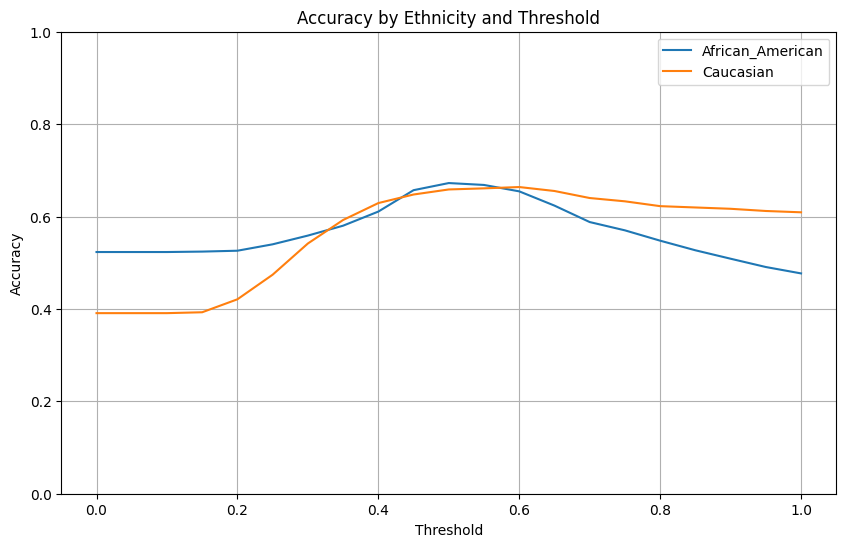

In [49]:
# prompt: Create a graph showing the accuracy at different thresholds for each ethnicity.
#Accuracy is defined as the share of correct predictions.
#A correct prediction is either a case where recidivism = 1 and the individual is classified positive because their probability is at or above the threshold
# or recidivism = 0 and the individual is classified as negative because their probability is below the threshold.

# Create a series of threshold cutoffs ranging from 5 to 100% in steps of 5%.
thresholds = [x/100 for x in range(0, 101, 5)] #We go to 101 here so we capture 100%
accuracy_by_ethnicity = {}

for ethnicity in df['ethnicity'].unique():
    accuracy_by_ethnicity[ethnicity] = []
    for threshold in thresholds:
        # Filter data by ethnicity
        ethnicity_df = df[df['ethnicity'] == ethnicity]

        # Calculate accuracy
        correct_predictions = ethnicity_df[((ethnicity_df['recidivism'] == 1) & (ethnicity_df['probability'] >= threshold)) | ((ethnicity_df['recidivism'] == 0) & (ethnicity_df['probability'] < threshold))]
        accuracy = len(correct_predictions) / len(ethnicity_df) if len(ethnicity_df) > 0 else 0
        accuracy_by_ethnicity[ethnicity].append(accuracy)

# Create the plot
plt.figure(figsize=(10, 6))
for ethnicity, accuracy in accuracy_by_ethnicity.items():
    plt.plot(thresholds, accuracy, label=ethnicity)

plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy by Ethnicity and Threshold")
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()


So now we can see that the accuracy for the African American group peaks right around a threshold of 50% (which was what was used to classify). The accuracy is slightly higher for Caucasians at a threshold of 60% than at 50%, but the differences are small. For any threshold between 40% and 60%, we see that the algorithm would produce accuracy rates that are within about 1% across ethnicity groups. As noted above, the larger disparities as we look at thresdholds toward 0 or 1 are expected and reflect the differences in base rates by ethnicity group.

##ROC-AUC analysis
A final comparison of model accuracy by ethnicity is to compare the Receiver Operating Curve (ROC) and the Area Under the Curve (AUC) for each group.

This code does that for us:

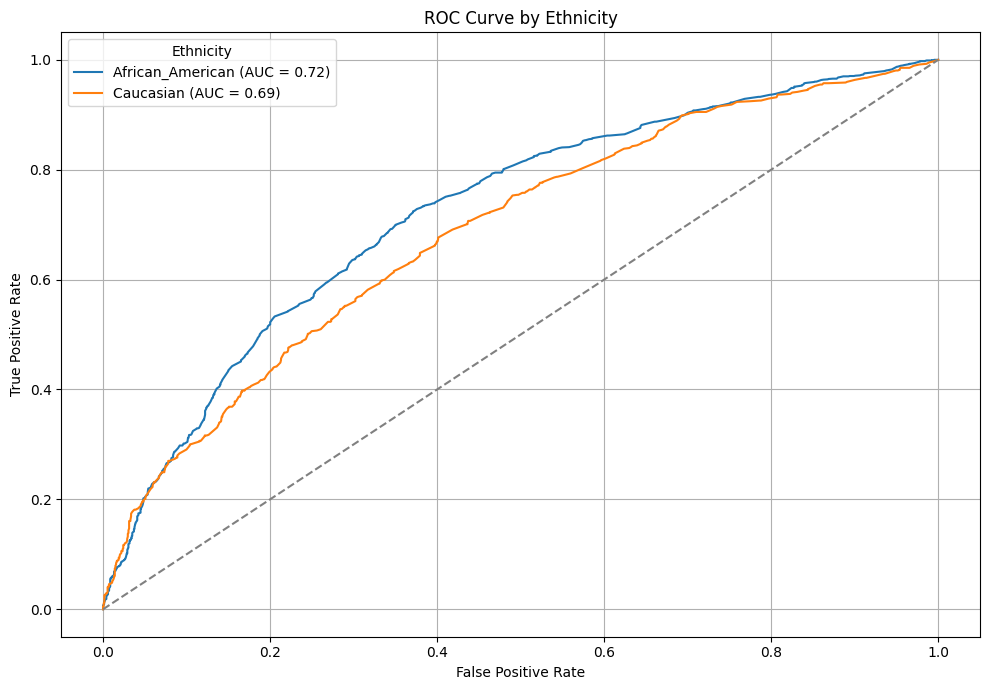

In [50]:
#Get the libraries needed
#import pandas as pd
#import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Get list of ethnicities
ethnicities = df['ethnicity'].unique()

# Initialize plot
plt.figure(figsize=(10, 7))

# Compute and plot ROC curve for each ethnicity
for group in ethnicities:
    group_df = df[df['ethnicity'] == group]
    y_true = group_df['recidivism']
    y_score = group_df['probability']

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{group} (AUC = {roc_auc:.2f})')

# Plot the diagonal line for random chance
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customize plot
plt.title('ROC Curve by Ethnicity')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(title='Ethnicity')
plt.grid(True)
plt.tight_layout()
plt.show()


What we see here is that the ROC curve is shifted up a little for the African American group relative to Caucasians, indicating that the model predicts with better precision for the African American group. This is also reflected in the slightly higher area under the curve (AUC) metric for the African American group. These differences likely arise in part because the African American group has a somewhat wider distribution of predicted values than the Caucasian group (as we saw in the Kernel Density plot above). However, the overall take away here is that both models have fair, but not great, predictive ability. An AUC of around 70% is often seen as "fair" or "acceptable" for classificaiton, though it is hard to set any absolute standard. The overall difference between the ethnic groups is also small. The main take away seems to be that the model is not very different in its predictive ability for Caucasians vs. African Americans.

#Analysis of Differential Error Rates
Now we turn to analyzing the nature of the errors this algorithm creates in classification. The Propublica article focced on differential error rates rather than on overall model calibration. Let us look at what that analysis looks like here.

Some main metrics we are interested in are (Propublica Focus):

1.   False positive rate (FPR): The share of those who do not recidivate who are wrongly classified as predicted = 1. FP/(FP+TN)
2.   False negative rate (FNR): The share of those who do recidivate who are wrongly classified as predicted = 0. FN/(TP+FN)

We might also want to look at the share of predictions of each type that turn out to be correct. The key metrics here are:

1.   False Detection Rate (FDR), which is 1-Precision: The share of cases classified as predicted = 1 that turned out not to recidivate. FP/(TP+FP)
2.   Fals Omission Rate (FOR), which is 1-Negative Predicted Value: The share of cases classified as predicted = 0 that turned out to recidivate. FN/(FN+TN)





##False Positive and Negative Rates
Let's first calculate the FPR and FNR by ethnicity at the at the classification from the variable **predicted** (recall based on threshold of probability = 50%).


In [54]:
# Create a table of the False Positive Rate and False Negative Rate by ethnicity.

# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
# Recidivism = 1 is the positive class
# Predicted = 1 is the positive prediction

df['TP'] = ((df['recidivism'] == 1) & (df['predicted'] == 1)).astype(int)
df['FP'] = ((df['recidivism'] == 0) & (df['predicted'] == 1)).astype(int)
df['TN'] = ((df['recidivism'] == 0) & (df['predicted'] == 0)).astype(int)
df['FN'] = ((df['recidivism'] == 1) & (df['predicted'] == 0)).astype(int)

# Group by ethnicity and calculate sums of TP, FP, TN, FN
confusion_matrix_by_ethnicity = df.groupby('ethnicity')[['TP', 'FP', 'TN', 'FN']].sum()

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
# FPR = FP / (FP + TN)
# FNR = FN / (TP + FN)

confusion_matrix_by_ethnicity['FPR'] = confusion_matrix_by_ethnicity['FP'] / (confusion_matrix_by_ethnicity['FP'] + confusion_matrix_by_ethnicity['TN'])
confusion_matrix_by_ethnicity['FNR'] = confusion_matrix_by_ethnicity['FN'] / (confusion_matrix_by_ethnicity['TP'] + confusion_matrix_by_ethnicity['FN'])

# Select only the FPR and FNR columns and round to 2 decimal places
error_rates_table = confusion_matrix_by_ethnicity[['FPR', 'FNR']].round(2)

# Print the table
print(error_rates_table)


                   FPR   FNR
ethnicity                   
African_American  0.42  0.25
Caucasian         0.22  0.53


Consistent with the Propublica Analysis, we see that the False Positive Rate is significantly higher for African Americans (42% vs. 22%) and the False Negative Rate is significantly higher for Caucasians (53% vs. 25%).

Another thing we can do is look at how the FPR and FNR would look at any different classification threshold that might have been chosen. To do this we repeat our analysis but now rather than using the classification based on **predicted**, we calculate the FPR and FNR at different classifications based on different thresholds in the predicted probability.

Here is code that will do that. I use blue to denote African American and orange for Caucasian and use solid lines for FPR and dashed lines for FNR.

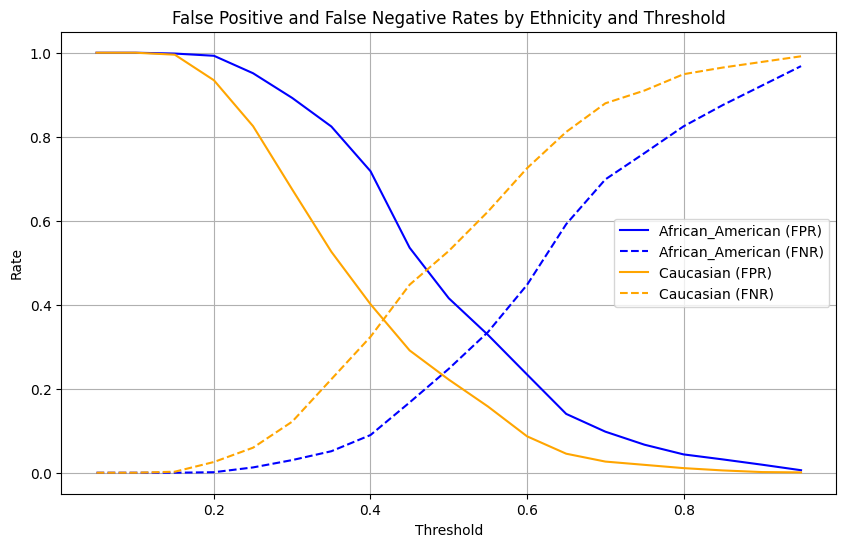

In [63]:
# Create a graph showing False Positive Rates and False Negative Rates by Ethnicity at different classification thresholds

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'probability', 'recidivism', and 'ethnicity' columns exist
thresholds = [x/100 for x in range(5, 100, 5)]
false_positive_rates = {}#Creating an empty dictionary to hold the values
false_negative_rates = {}

for ethnicity in df['ethnicity'].unique():
    false_positive_rates[ethnicity] = []
    false_negative_rates[ethnicity] = []
    for threshold in thresholds:
        # Filter data by ethnicity
        ethnicity_df = df[df['ethnicity'] == ethnicity]

        # Calculate false positive rate
        false_positives = ethnicity_df[(ethnicity_df['recidivism'] == 0) & (ethnicity_df['probability'] >= threshold)]
        false_positive_rate = len(false_positives) / len(ethnicity_df[ethnicity_df['recidivism'] == 0]) if len(ethnicity_df[ethnicity_df['recidivism'] == 0]) > 0 else 0
        false_positive_rates[ethnicity].append(false_positive_rate)

        # Calculate false negative rate
        false_negatives = ethnicity_df[(ethnicity_df['recidivism'] == 1) & (ethnicity_df['probability'] < threshold)]
        false_negative_rate = len(false_negatives) / len(ethnicity_df[ethnicity_df['recidivism'] == 1]) if len(ethnicity_df[ethnicity_df['recidivism'] == 1]) > 0 else 0
        false_negative_rates[ethnicity].append(false_negative_rate)


# Create the plot
plt.figure(figsize=(10, 6))
for ethnicity in df['ethnicity'].unique():
    if ethnicity == 'African_American':
        color = 'blue'
    elif ethnicity == 'Caucasian':
        color = 'orange'
    else:
        color = 'gray'  # Default color for other ethnicities

    plt.plot(thresholds, false_positive_rates[ethnicity], label=f'{ethnicity} (FPR)', color=color)
    plt.plot(thresholds, false_negative_rates[ethnicity], label=f'{ethnicity} (FNR)', linestyle='--', color=color) # Use dashed lines for FNR

plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("False Positive and False Negative Rates by Ethnicity and Threshold")
plt.legend()
plt.grid(True)
plt.show()


So what do we see here? Well we can see that at every threshold of probability that could be used for classification the False Positive Rate is higher for the African American Group and the False Negative Rate is higher for the Caucasian group.

## False Detection and Ommission Rates
Ok, now let's do the same thing focusing on FDR and FOR.

Let's first calculate the FDR and FOR by ethnicity at the at the classification from the variable **predicted** (recall based on threshold of probability = 50%).

In [58]:
# Create a table of the False Discovery Rate and False Ommission Rate by ethnicity.

# Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
# Recidivism = 1 is the positive class
# Predicted = 1 is the positive prediction

df['TP'] = ((df['recidivism'] == 1) & (df['predicted'] == 1)).astype(int)
df['FP'] = ((df['recidivism'] == 0) & (df['predicted'] == 1)).astype(int)
df['TN'] = ((df['recidivism'] == 0) & (df['predicted'] == 0)).astype(int)
df['FN'] = ((df['recidivism'] == 1) & (df['predicted'] == 0)).astype(int)

# Group by ethnicity and calculate sums of TP, FP, TN, FN
confusion_matrix_by_ethnicity = df.groupby('ethnicity')[['TP', 'FP', 'TN', 'FN']].sum()

# Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
# FDR = FP / (FP + TP)
# FOR = FN / (FN + TN)

confusion_matrix_by_ethnicity['FDR'] = confusion_matrix_by_ethnicity['FP'] / (confusion_matrix_by_ethnicity['FP'] + confusion_matrix_by_ethnicity['TP'])
confusion_matrix_by_ethnicity['FOR'] = confusion_matrix_by_ethnicity['FN'] / (confusion_matrix_by_ethnicity['FN'] + confusion_matrix_by_ethnicity['TN'])

# Select only the FPR and FNR columns and round to 2 decimal places
error_rates_table = confusion_matrix_by_ethnicity[['FDR', 'FOR']].round(2)

# Print the table
print(error_rates_table)

                   FDR   FOR
ethnicity                   
African_American  0.33  0.32
Caucasian         0.42  0.30


Now the error rates based on conditioning on the prediction (FDR and FOR) show a different picture than what we saw for the error rates conditioned on the outcome class (FPR and FNR). The FDR is lower for African Americans (33% vs 42%). This tells us that among those classified as high risk for African Americans, the prediction was wrong 33% of the time, while it was wrong 42% of the time for Caucasians. The false ommission rate is similar for both groups at 32% of those predicted low risk showing recidivism for African Americans and 30% for Caucasians.

We can also reproduce our graph showing error rates at different thresholds now for the FDR and FOR.

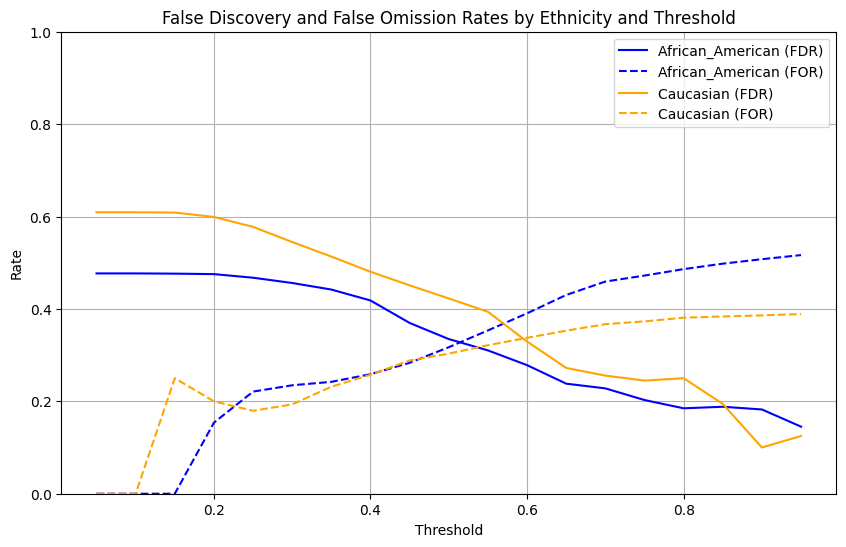

In [64]:
# Create a graph of the FDR and FOR at different classification thresholds
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

thresholds = [x / 100 for x in range(5, 100, 5)]
false_discovery_rates = {}
false_omission_rates = {}

for ethnicity in df['ethnicity'].unique():
    false_discovery_rates[ethnicity] = []
    false_omission_rates[ethnicity] = []

    for threshold in thresholds:
        ethnicity_df = df[df['ethnicity'] == ethnicity]

        # Predictions
        predicted_positive = ethnicity_df[ethnicity_df['probability'] >= threshold]
        predicted_negative = ethnicity_df[ethnicity_df['probability'] < threshold]

        # FDR = False Positives / Predicted Positives
        false_positives = predicted_positive[predicted_positive['recidivism'] == 0]
        fdr = len(false_positives) / len(predicted_positive) if len(predicted_positive) > 0 else 0
        false_discovery_rates[ethnicity].append(fdr)

        # FOR = False Negatives / Predicted Negatives
        false_negatives = predicted_negative[predicted_negative['recidivism'] == 1]
        for_ = len(false_negatives) / len(predicted_negative) if len(predicted_negative) > 0 else 0
        false_omission_rates[ethnicity].append(for_)

# Plotting
plt.figure(figsize=(10, 6))

for ethnicity in df['ethnicity'].unique():
    if ethnicity == 'African_American':
        color = 'blue'
    elif ethnicity == 'Caucasian':
        color = 'orange'
    else:
        color = 'gray'

    plt.plot(thresholds, false_discovery_rates[ethnicity], label=f'{ethnicity} (FDR)', color=color)
    plt.plot(thresholds, false_omission_rates[ethnicity], label=f'{ethnicity} (FOR)', linestyle='--', color=color)

plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("False Discovery and False Omission Rates by Ethnicity and Threshold")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()


So now we see that the basic conclusion we had at the baseline threshold again holds across a range of possible thresholds we could have chosen. The False Discovery Rate is modestly higher for Caucasians at almost all thresholds and the False Ommission Rate is modestly higher for African Americans at most thresholds.

# Summing up
Now that you have gone through this lab you can see how we can analyze a prediction algorithm for fairness in a few steps. These are:


1.   Compare the base rates, distribution of predicted probabilties, and rates of positive classification at the chosen classification threshold across groups.
2.   Analyze the model for calibration and accuracy and compare these across groups.
3.   Compare error rates across groups. Ideally look at both rates conditional on knowing the true class (FPR and FNR) and conditional on the predicted class (FDR and FOR).

As we see in this case, the analysis in steps 2 and 3 may not give a consistent picture of fainess and disparities across groups. The implications one draws for the appropriateness of using the model needs to depend on the context the model is used in and ethical judgments.

